In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from warnings import filterwarnings
from sklearn.preprocessing import MinMaxScaler

# filterwarnings('ignore')

# Load the Titanic dataset
titanic_df = pd.read_csv('./train.csv')




In [2]:
# Drop columns that are not useful for prediction
titanic_df = titanic_df.drop(['Name', 'Cabin'], axis=1)

In [3]:
titanic_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked'],
      dtype='object')

In [4]:
# Define features and target variable
X = titanic_df.drop('Survived', axis=1)
y = titanic_df['Survived']

In [5]:
# Handle missing values
X['Age'].fillna(X['Age'].median(), inplace=True)
X['Embarked'].fillna(X['Embarked'].mode()[0], inplace=True)

In [6]:
# Convert categorical variables to numerical
encoder = LabelEncoder()
X['Sex'] = encoder.fit_transform(X['Sex'])
X['Embarked'] = encoder.fit_transform(X['Embarked'])
X['Ticket'] = encoder.fit_transform(X['Ticket'])

In [7]:
numeric_cols = X.select_dtypes(np.number).columns.to_list()

scaler = MinMaxScaler()

scaler.fit(X[numeric_cols])

X[numeric_cols] = scaler.transform(X[numeric_cols])

In [8]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

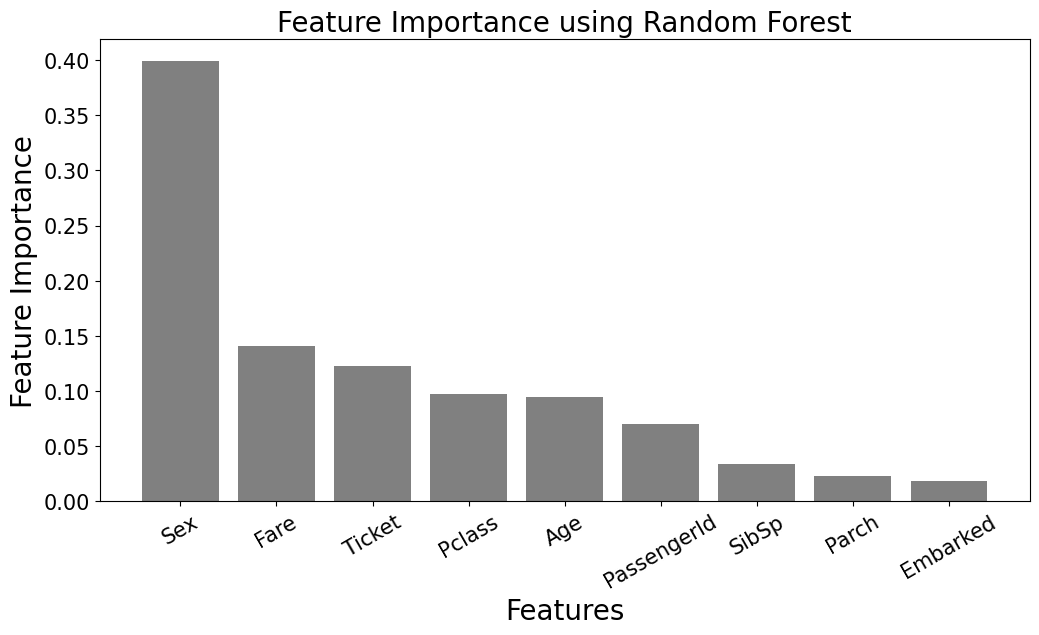

In [9]:
# Train Random Forest classifier

rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

rf_classifier = RandomForestClassifier(n_estimators=500, random_state=1, min_samples_leaf=2, max_depth=6,warm_start=True, \
                                       verbose=0)
rf_classifier.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

weighhh_df = pd.DataFrame({
    'features': X.columns,
    'weights': feature_importances
})

weighhh_df.sort_values(['weights'], ascending=False,inplace=True)

#Plot relative feature importance
plt.figure(figsize=(12, 6))
plt.bar(weighhh_df['features'], weighhh_df['weights'], color='gray')
plt.xlabel('Features', fontsize=20)
plt.ylabel('Feature Importance', fontsize=20)
plt.title('Feature Importance using Random Forest', fontsize=20)
# plt.gca().invert_yaxis()
plt.savefig('rf.png')
plt.xticks(fontsize=15, rotation=30)
plt.yticks(fontsize=15)
plt.show()


In [10]:
feats = weighhh_df['features'].unique()
feats

array(['Sex', 'Fare', 'Ticket', 'Pclass', 'Age', 'PassengerId', 'SibSp',
       'Parch', 'Embarked'], dtype=object)

In [11]:
hey = []
threshold = 0.75
for i in range(len(feats)):
    hey.append(feats[i])
    ttt = X_train[hey]
    model = LogisticRegression(random_state=42).fit(ttt, y_train)
    predictions = model.predict(X_test[hey])
    accuracy = accuracy_score(y_test, predictions)
    
    print(f"Features: {hey}\t Accuracy: {accuracy}")

Features: ['Sex']	 Accuracy: 0.7821229050279329
Features: ['Sex', 'Fare']	 Accuracy: 0.7821229050279329
Features: ['Sex', 'Fare', 'Ticket']	 Accuracy: 0.7821229050279329
Features: ['Sex', 'Fare', 'Ticket', 'Pclass']	 Accuracy: 0.7821229050279329
Features: ['Sex', 'Fare', 'Ticket', 'Pclass', 'Age']	 Accuracy: 0.7932960893854749
Features: ['Sex', 'Fare', 'Ticket', 'Pclass', 'Age', 'PassengerId']	 Accuracy: 0.7988826815642458
Features: ['Sex', 'Fare', 'Ticket', 'Pclass', 'Age', 'PassengerId', 'SibSp']	 Accuracy: 0.8044692737430168
Features: ['Sex', 'Fare', 'Ticket', 'Pclass', 'Age', 'PassengerId', 'SibSp', 'Parch']	 Accuracy: 0.8044692737430168
Features: ['Sex', 'Fare', 'Ticket', 'Pclass', 'Age', 'PassengerId', 'SibSp', 'Parch', 'Embarked']	 Accuracy: 0.7932960893854749
